# Zero-shot classification with DOTA 2 in-game chats

In this notebook, I would like to make a rapid introduction to zero-shot classification for practitioners. We will cover what it is and explore a use case. 

This is not a comprehensive tutorial, nor does it discuss efficient approaches. Still, it's more like a taste of zero-shot classification in practice for those with no experience with it. 

After being positively surprised, I prepared this notebook, and I wanted to share what I see as a potentially game-changing technique to apply machine learning when ground-truth labels are not available. 


## Zero-shot learning, what is that?!

Ian Goodfellow's answered in Quora (https://qr.ae/pGl1ss).

```
Zero-shot learning is being able to solve a task despite not having received any training examples of that task.
```

He answered the question quite some time ago, so this is not a new thing. In computer vision, people have been investigating that since 2008, according to Wikipedia. 

In NLP, this is being more materialized recently with advances in transfer learning. New architectures are being proposed and because there are some interesting datasets where bigger models can be pre-trained on. 

The most common example you will see out there about zero-shot learning is the zebra example. Suppose you only trained your model with horses. Now you want to classify a zebra, but your model doesn't know about it. But if you are able to say to the model that "zebra"s (a new label) are striped and horse-like (features), a model able to perform zero-shot learning can correctly identify that zebra.

## Okay, but is that possible?

Of course. Zero-shot learning is a particular form of transfer learning. That there are different ways to do the job, and techniques vary in computer vision and NLP. 

In this notebook, we will walk through how you can put your hands in some unlabeled text data and label it automatically using models available from HuggingFace's `transformers`. 

## I don't have too much time. Can you show me this quickly?

Sure, I understand. First, I will show a small demonstration.   

If you want to go through a second example, I will use some data from DOTA-2 chats to classify them as one of the following `candidate_labels = ['chitchat', 'game features', 'coordination', 'toxic offense', 'gender discrimination', 'religious intolerance', 'racism']`. This data is in Russian, so we have a translation step in between. But it seems that there are zero-shot models in a few other languages available out there, such as French, Spanish, German, even Russian. See a list from HuggingFace [models](https://huggingface.co/models?pipeline_tag=zero-shot-classification&sort=downloads).

In [1]:
#hide

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
plt.rcParams.update({'font.size': 18, "font.family": "Times"})

## Example 1: Reasoning or personal impression?

This is an example taken from [Fiacco & Rosé (2018)](https://dl.acm.org/doi/pdf/10.1145/3231644.3231655).

Suppose you want to classify a text as a ***causal reasoning***, a ***evaluation reasoning*** or a ***personal impression***. 

If someone says 
* "Use of coal increases pollution", we expect the label to be ***causal reasoning***.
* "Use of wind power may not be reliable throughtout the year", we expect the label to be ***evaluation reasoning***.
* "I prefer coal power", we expect the label to be ***personal impression***.

Of course, these are not completely exclusive classes and could be better conceived to be exclusive, but suppose these are exclusive.

We can use a pre-trained model that is able to perform zero-shot learning and generate labels without any previous training data:

In [2]:
from transformers import AutoTokenizer, pipeline
from transformers import AutoModelForSequenceClassification

def zeroshot_classifier():
    # Only works with English text
    tokenizer = AutoTokenizer\
                    .from_pretrained("facebook/bart-large-mnli")
    model = AutoModelForSequenceClassification\
                    .from_pretrained("facebook/bart-large-mnli")
    return pipeline(task='zero-shot-classification',
                    model=model, tokenizer=tokenizer)

pipe = zeroshot_classifier()

some_texts = ["Use of coal increases pollution", 
              "Use of wind power may not be reliable throughout the year",
              "I prefer coal power"]

candidate_labels = ['causal reasoning', 
                    'evaluation reasoning', 
                    'personal impression']

predictions = pipe(some_texts, 
                   candidate_labels=candidate_labels)

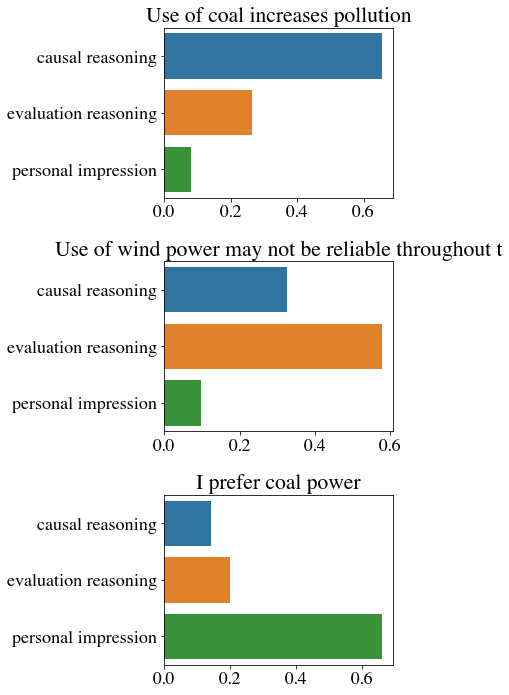

In [3]:
fig, ax = plt.subplots(nrows=3, 
                       figsize=(6,10))

for i, p in enumerate(predictions):
    sns.barplot(y='labels', x='scores', data=p, ax=ax[i], 
                order=candidate_labels)
    ax[i].set_title(p['sequence'][:50])

fig.tight_layout()

### Why does this work?

I suggest you read the [description of the model](https://huggingface.co/facebook/bart-large-mnli) we are using here, they answer this question in very simply.

If you want to read my own (shorter) explanation of their explanation, here it is:

To understand the explanation, you need to know what is a NLI (Natural language inference) dataset. There are a few different NLI datasets out there, for example SNLI and MultiNLI are the most famous ones. In the task of these datasets, there is two pieces of texts, a premise and a hypotehsis. The option of labels are `entailment` (when the hypothesis confirms the premise), `contradiction` (when the hypothesis denies the premise), and `neutral`. Check some examples [here](https://cims.nyu.edu/~sbowman/multinli/). Some people call NLI's task as the entailment classification task.

The MultiNLI dataset is huge and enables robust algorithm architectures to produce very good models that can be transferred to other semantically similar tasks.

Suppose the model does a great job at the entailment task. Given our set of three `candidate_labels`, zero-shot learning with can be leveraged in the following way. Take the input text as the premise. For each `i`th `candidate_labels`, turn the  into *"This sentence is about {i}"* and that is used as our hypothesis, predict the entailment of this hypothesis. Finally, transform the output to generate a probability for each `candidate_label`.


Let's go through another example to see it in action in a harder context.

## Example 2: DOTA-2 in-game chats

*Disclaimer: The dataset for this example contains text that may be considered profane, vulgar, or offensive.* 

### a. Load the data

In [4]:
df = pd.read_csv('~/Downloads/dota2_chat_messages.csv', nrows=100)

df['text'] = df['text'].fillna('')
print('Previous mean length of text', df['text'].apply(lambda x: len(x)).mean())
print('Removing 1% outliers of really big texts...')
max_size_message = int(df['text'].apply(len).quantile(.99))
df['text'] = df['text'].apply(lambda x: x[:max_size_message])

print('Mean length of text', df['text'].apply(lambda x: len(x)).mean(), '\n\n')
print(df.head(15))

Previous mean length of text 11.83
Removing 1% outliers of really big texts...
Mean length of text 11.72 


    match        time  slot                                text
0       0  1005.12122     9                           ладно гг 
1       0  1005.85442     9                                 изи
2       0  1008.65372     9                                  од
3       0  1010.51992     9                              ебаный
4       0  1013.91912     9                      мусор на войде
5       0  1800.31402     9                              мусор 
6       0  1801.71882     9                            на войде
7       0  1802.98982     9                              репорт
8       0  1808.40822     9                                100%
9       1  -131.14018     0              twitch.tv/rage_channel
10      1  -121.60481     0  https://www.twitch.tv/rage_channel
11      1   244.47367     7                      2 даша подряд 
12      1   249.93900     7                               ба

In [5]:
df_sample = df.sample(30)

### b. Translate to English

In [6]:
from transformers import AutoModelForSeq2SeqLM

def translator(src: str, dest: str):
    src = src.lower()
    dest = dest.lower()
    tokenizer = AutoTokenizer\
                    .from_pretrained(f"Helsinki-NLP/opus-mt-{src}-{dest}")
    model = AutoModelForSeq2SeqLM\
                    .from_pretrained(f"Helsinki-NLP/opus-mt-{src}-{dest}")
    return pipeline(task='translation',
                    model=model, tokenizer=tokenizer)

translate = translator('ru', 'en')

In [7]:
%%time
translated_text = translate([t[:max_size_message] for t in list(df_sample['text'])])
df_sample['text_en'] = [t['translation_text'] for t in translated_text]

CPU times: user 2min 28s, sys: 1min 25s, total: 3min 54s
Wall time: 3min 7s


In [8]:
df_sample.head(10)

,match,time,slot,text,text_en
25,2,1248.42850,0,yes dog,yes dog
56,3,2371.22080,6,я говор.,I'm a talker.
22,1,716.05853,6,стример харду сливает)0)),strimer hardu drips off)0))
59,3,2516.98400,2,),)
62,4,-38.79053,1,профиль глянь :D,Look at the profile:D
27,2,1281.95360,4,HAHAH,HAHAH
15,1,597.98733,4,долбоеб сука на дизрапторе,Fucking bitch on disraptor.
57,3,2376.30480,6,У тебя мать портовая шлюха,Your mother's a port whore.
44,3,145.63110,0,ты это антимагу написаЛ?,Did you write that anti-maga?
38,2,2263.90490,4,COMMEND ME TY,COMMEND ME TY


### c. Load zero-shot classifier from Huggingface's transformers library

In [9]:
pipe = zeroshot_classifier()

### d. Define your candidate labels

In [10]:
candidate_labels = ['chitchat', 'game features', 'coordination', 
                    'toxic offense', 'gender discrimination', 
                    'religious intolerance', 'racism']

### e. Generate and explore predictions

In [11]:
%%time
predictions = pipe(list(df_sample['text_en']), candidate_labels=candidate_labels)
predictions[0]

CPU times: user 4min 6s, sys: 28.4 s, total: 4min 34s
Wall time: 4min 34s


{'sequence': 'yes dog',
 'labels': ['coordination',
  'chitchat',
  'toxic offense',
  'game features',
  'racism',
  'religious intolerance',
  'gender discrimination'],
 'scores': [0.5105039477348328,
  0.14312249422073364,
  0.11186554282903671,
  0.07289346307516098,
  0.06860581040382385,
  0.05673101544380188,
  0.03627773001790047]}

In [12]:
labels = []
for p in predictions:
    labels.append(p['labels'][np.argmax(p['scores'])])

df_sample['label'] = labels

df_sample[['text', 'text_en', 'label']]

,text,text_en,label
25,yes dog,yes dog,coordination
56,я говор.,I'm a talker.,chitchat
22,стример харду сливает)0)),strimer hardu drips off)0)),coordination
59,),),chitchat
62,профиль глянь :D,Look at the profile:D,chitchat
27,HAHAH,HAHAH,chitchat
15,долбоеб сука на дизрапторе,Fucking bitch on disraptor.,toxic offense
57,У тебя мать портовая шлюха,Your mother's a port whore.,toxic offense
44,ты это антимагу написаЛ?,Did you write that anti-maga?,gender discrimination
38,COMMEND ME TY,COMMEND ME TY,coordination


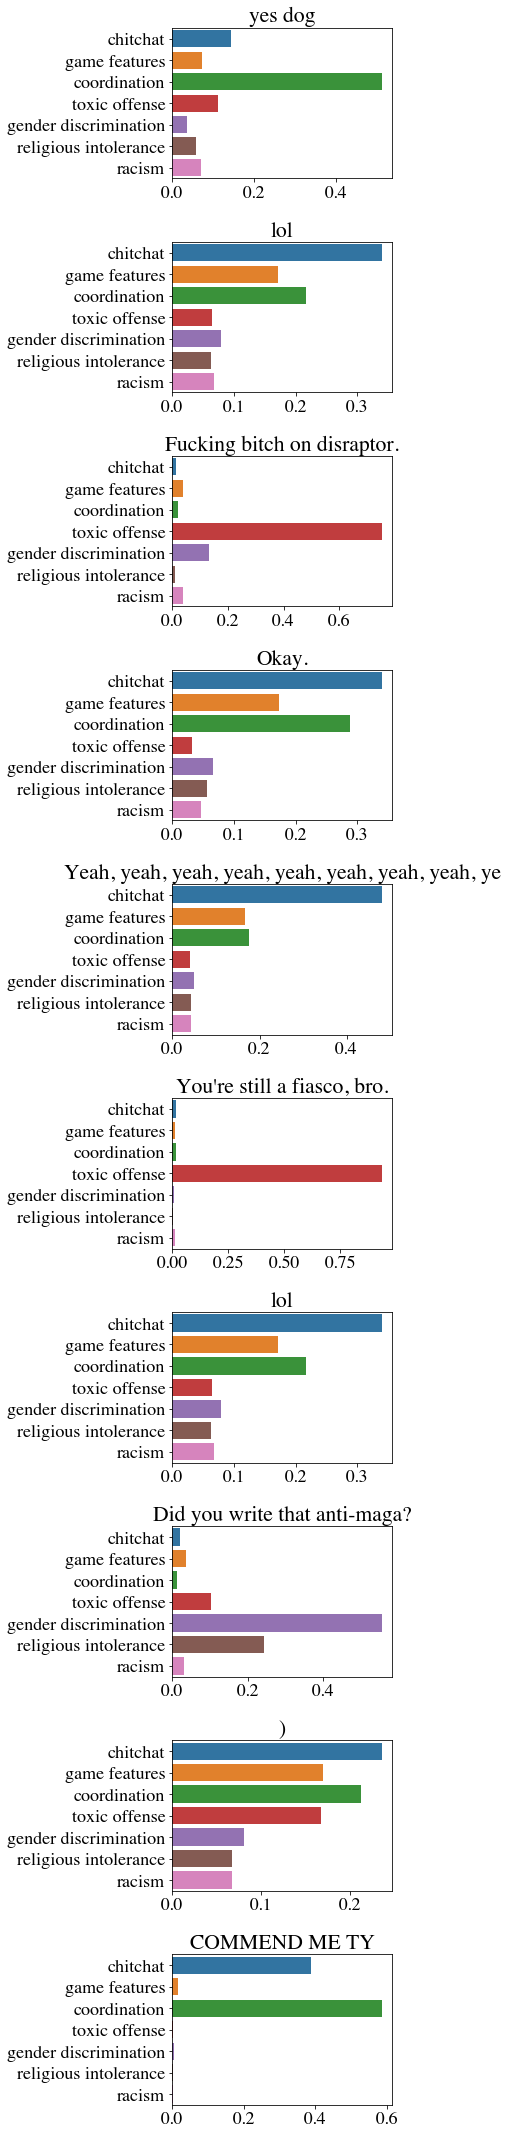

In [18]:
how_many_to_plot = 10

fig, ax = plt.subplots(nrows=how_many_to_plot, 
                       figsize=(6,30))

for i, p in enumerate(random.sample(predictions, how_many_to_plot)):
    sns.barplot(y='labels', x='scores', data=p, ax=ax[i], 
                order=candidate_labels)
    ax[i].set_title(p['sequence'][:50])

fig.tight_layout()

In case you want to know more about zero-shot learning, I encourage you to go through the following material:

* https://joeddav.github.io/blog/2020/05/29/ZSL.html
* https://arxiv.org/abs/1909.00161
* https://www.deeplearningbook.org/contents/representation.html (Section 15.2)
* https://www.aaai.org/Papers/AAAI/2008/AAAI08-132.pdf

As a takeaway, I think a well designed zero-shot classifier (with good candidate labels) can be game-changing tool for several AI projects. 

One use case is for example "expert systems", where you generate these output probabilities for classes that you understand as intermediary features that you provide to a rule-based decision-making mechanism. Then you are able to write things like "if causal_reasoning is high, do the action A; if evaluation_reasoning is high do the action B". I think there has some research opportunity with zero-shot learning as a feature engineering step because with this kind of system, although features are computed from black box models, your features are abstractions that you can understand and explain. Also, if you build `candidate_labels` using some theory, that is great for you because you have more evidence to back up your design.

The main issue I see with this is how can we evaluate if the zero-shot labels are good. Well, one way to measure is by letting the model compute several labels, and then you or another person can label manually. With your labels and the zero-shot ones, you can use Cohen's Kappa as your agreement level. That, however, is not scalable when you are testing several `candidate_labels`.

If you see interesting use cases for zero-shot learning, or want to interact/discuss about this notebook, please comment below!!